# Image classification


## It classifies images of flowers. It creates an image classifier using a keras.Sequential model, and loads data using preprocessing.image_dataset_from_directory.

## machine learning workflow:
### Examine and understand data
### Build an input pipeline
### Build the model
### Train the model
### Test the model
### Improve the model and repeat the process

In [1]:
!pip install tf-nightly

  Using cached tf_nightly-2.4.0.dev20200828-cp37-cp37m-win_amd64.whl (284.4 MB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Attempting uninstall: keras-preprocessing
    Found existing installation: Keras-Preprocessing 1.1.0
    Uninstalling Keras-Preprocessing-1.1.0:
      Successfully uninstalled Keras-Preprocessing-1.1.0


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Python Imaging Library (abbreviated as PIL) (in newer versions known as Pillow) is a free and open-source additional library for the Python programming language that adds support for opening, manipulating, and saving many different image file formats.

### A dataset of about 3,700 photos of flowers. The dataset contains 5 sub-directories, one per class:

### flower_photo/
  ### daisy/
  ### roses/
  ### sunflowers/
  ### tulips/

In [2]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


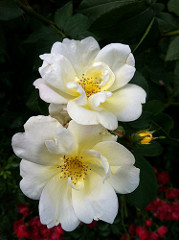

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

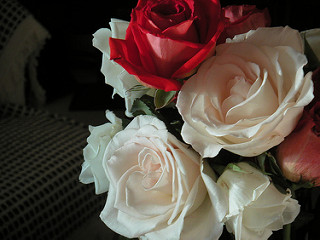

In [5]:
PIL.Image.open(str(roses[1]))

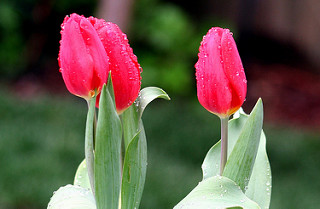

In [6]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

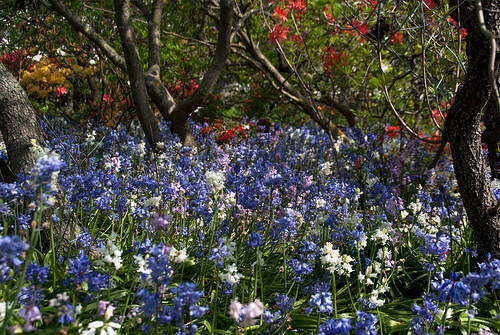

In [7]:
PIL.Image.open(str(tulips[1]))

# Load using keras.preprocessing
### Let's load these images off disk using the helpful image_dataset_from_directory utility. This will take you from a directory of images on disk to a tf.data.Dataset

In [8]:
batch_size = 32
img_height = 180
img_width = 180

#### The seed() method is used to initialize the random number generator. The random number generator needs a number to start with (a seed value), to be able to generate a random number.

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


# Visualize the data

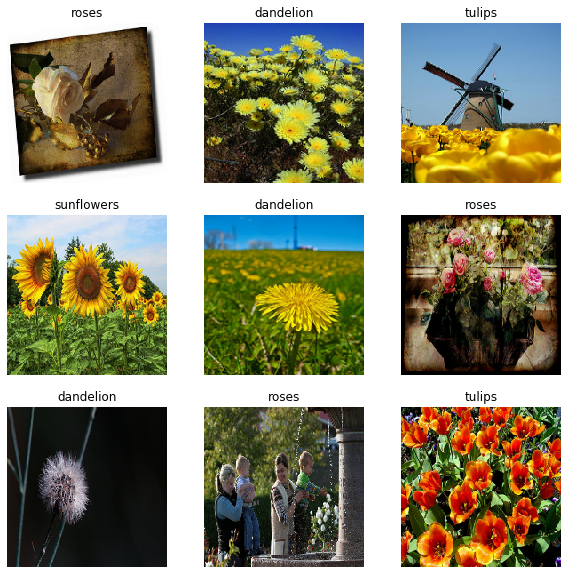

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


#### The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension referes to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

# Configure the dataset for performance
### Let's make sure to use buffered prefetching so we can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.
### Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
### Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Standardize the data
### The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general you should seek to make your input values small. Here, we will standardize values to be in the [0, 1] by using a Rescaling layer.

In [15]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [16]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


# Create the model

In [17]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Keras Conv2D is a 2D Convolution Layer, this layer creates a convolution kernel that is wind with layers input which helps produce a tensor of outputs.
### Max pooling is a sample-based discretization process. The objective is to down-sample an input representation (image, hidden-layer output matrix, etc.), reducing its dimensionality and allowing for assumptions to be made about features contained in the sub-regions binned.
### Max pooling is a pooling operation that selects the maximum element from the region of the feature map covered by the filter. Thus, the output after max-pooling layer would be a feature map containing the most prominent features of the previous feature map.
### Convolutional layers are the major building blocks used in convolutional neural networks. A convolution is the simple application of a filter to an input that results in an activation. ... The result is highly specific features that can be detected anywhere on input images.
### Is Max pooling necessary?
### So one approach is to aggregate statistics of these features at various locations like calculating the max , min or mean value of a region over an image. This operation is called the Pooling operation. So a Pooling layer is not necessary but advisable to reduce the number of extracted features and to avoid overfitting.
### Flattening is converting the data into a 1-dimensional array for inputting it to the next layer. We flatten the output of the convolutional layers to create a single long feature vector. And it is connected to the final classification model, which is called a fully-connected layer.
### CNN can be applied on any 2D and 3D array of data.
### Pooling is a resource management term that refers to the grouping together of resources for the purposes of maximizing advantage and/or minimizing risk to the users. 



# Compile the model

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

# Train the model

In [20]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 185s 2s/step - loss: 1.4685 - accuracy: 0.3540 - val_loss: 1.1706 - val_accuracy: 0.5463
Epoch 2/10
92/92 [==============================] - 85s 929ms/step - loss: 1.0683 - accuracy: 0.5697 - val_loss: 0.9669 - val_accuracy: 0.6090
Epoch 3/10
92/92 [==============================] - 92s 995ms/step - loss: 0.8203 - accuracy: 0.6808 - val_loss: 0.9662 - val_accuracy: 0.6267
Epoch 4/10
92/92 [==============================] - 91s 993ms/step - loss: 0.5694 - accuracy: 0.7913 - val_loss: 0.9248 - val_accuracy: 0.6349
Epoch 5/10
92/92 [==============================] - 92s 1s/step - loss: 0.3671 - accuracy: 0.8756 - val_loss: 1.0628 - val_accuracy: 0.6458
Epoch 6/10
92/92 [==============================] - 97s 1s/step - loss: 0.2020 - accuracy: 0.9355 - val_loss: 1.0555 - val_accuracy: 0.6703
Epoch 7/10
92/92 [==============================] - 95s 1s/step - loss: 0.1150 - accuracy: 0.9676 - val_loss: 1.4679 - val_accuracy: 0.6662
Epoch 8/10

# Visualize training results

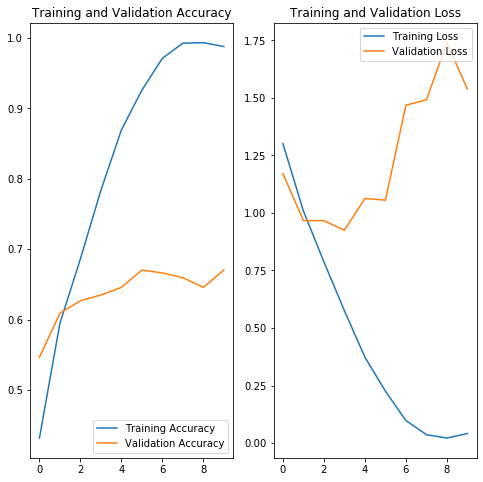

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### As you can see from the plots, training accuracy and validation accuracy are off by large margin and the model has achieved only around 60% accuracy on the validation set.

# Overfitting
### In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy sign of overfitting.
### When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.
### There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use data augmentation and add Dropout to your model.

# Data augmentation
### Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting then using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.
### We will implement data augmentation using experimental Keras Preprocessing Layers. These can be included inside your model like other layers, and run on the GPU.

In [22]:
 data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

### visualize what a few augmented examples look like by applying data augmentation to the same image several times:

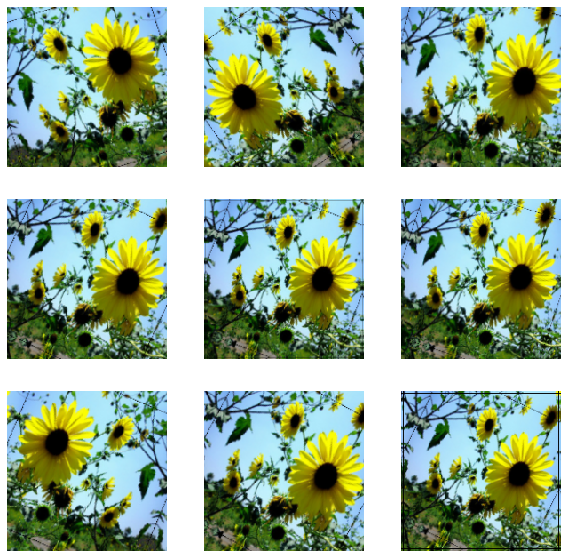

In [23]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Dropout

# Dropout to the network, a form of regularization.
### When you apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

In [24]:
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# Compile and train the model

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 45, 45, 64)       

In [27]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 104s 1s/step - loss: 1.4932 - accuracy: 0.3713 - val_loss: 1.1672 - val_accuracy: 0.5272
Epoch 2/15
92/92 [==============================] - 106s 1s/step - loss: 1.0609 - accuracy: 0.5756 - val_loss: 0.9829 - val_accuracy: 0.6117
Epoch 3/15
92/92 [==============================] - 116s 1s/step - loss: 0.9716 - accuracy: 0.6159 - val_loss: 0.9075 - val_accuracy: 0.6403
Epoch 4/15
92/92 [==============================] - 113s 1s/step - loss: 0.9282 - accuracy: 0.6471 - val_loss: 0.8473 - val_accuracy: 0.6676
Epoch 5/15
92/92 [==============================] - 115s 1s/step - loss: 0.8110 - accuracy: 0.6905 - val_loss: 0.8841 - val_accuracy: 0.6608
Epoch 6/15
92/92 [==============================] - 114s 1s/step - loss: 0.7912 - accuracy: 0.7078 - val_loss: 0.9318 - val_accuracy: 0.6281
Epoch 7/15
92/92 [==============================] - 109s 1s/step - loss: 0.7467 - accuracy: 0.7164 - val_loss: 0.7793 - val_accuracy: 0.6894
Epoch 8/15
92

# Visualize training results

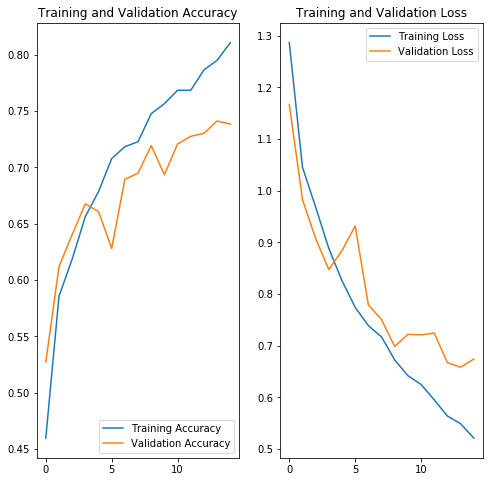

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Predict on new data

In [29]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

122880/117948 [===============================] - 0s 1us/step
This image most likely belongs to sunflowers with a 99.85 percent confidence.
